In [3]:
from __future__ import print_function

%matplotlib inline
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 

from matplotlib import pyplot as plt

import numpy as np

import skimage
from skimage.color import rgb2lab,rgb2gray, lab2rgb
from skimage.exposure import rescale_intensity, adjust_gamma, histogram
from skimage.filters import gaussian, median
from skimage import img_as_float, img_as_ubyte
from skimage.restoration import denoise_bilateral

import time

# Task 1
## a) Linear transformation

Import and show image. 

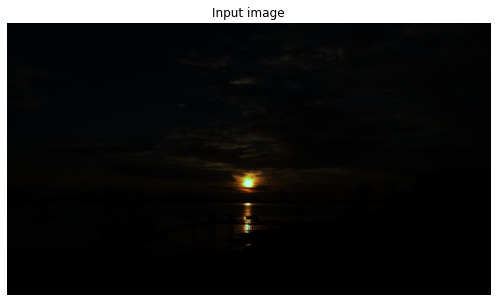

In [3]:
sea = imageio.imread('images/sea.hdr', format='HDR-FI') 
sea = sea/max(sea.flatten()) #scale image to range [0,1]

fig, ax = plt.subplots( figsize=(10,5))
ax.set_title('Input image')
plt.axis('off')
plt.imshow(sea, vmin = 0, vmax = 1)
plt.show()

The image obtained after the transformation performed by calling the **apply_transformation** method. The coefficients **A**, **B** and **C** were determined using the *ipywidgets.interact* tool.

In [4]:
def linear_scaling(input_image, coefficient):
    """
    Inputs:
        - input_image: input image
        - coefficient: pixel scaling coefficient (linear transformation)
    Output:
        scaled instensity image
    """
    return coefficient*input_image

def saturate_image(input_image, low, high):
    """
    inputs:
        - input_image: input image
        - low: lower pixel intensity limit, below which all pixels are saturated to 0
        - high: upper pixel intensity limit, above which all pixels will be saturated to 0
    Output:
        scaled image
    
    """
    input_image[input_image < low] = 0
    input_image[input_image > high] = 1
    return input_image

def apply_gamma_correction(input_image, gamma_coefficient):
    """
    Gamma transformation: output_image = input_image^(gamma_coefficient)
    Ulazi:
        - input_image: input image
        - gamma_coefficient: exponent
    Output:
        scaled image
    """
    return adjust_gamma(input_image, gamma_coefficient)

def apply_transformation(input_image, low, high, coefficient, gamma_coefficient = None):
    """
    Final transformation, calls previously definded functions.
    Output:
        transformed image
    """
    scaled_image = linear_scaling(input_image, coefficient)
    saturated_image = saturate_image(scaled_image, low, high)
    if gamma_coefficient is not None:
        output_image = apply_gamma_correction(saturated_image, gamma_coefficient)
        return output_image
    else:
        return saturated_image
    #fig, axis = plt.subplots(figsize = (16,8));
    #plt.axis('off')
    #plt.tight_layout()
    #plt.imshow(output_image, vmin=0, vmax=1)
    #plt.show()
#interact(apply_transformation,input_image=fixed(sea),low = fixed(0),high = fixed(1),gamma_coefficient = fixed(1/2.2), coefficient = (0, 50, 0.1))

In [5]:
A_gamma = 1.7
B_gamma = 12
C_gamma = 40.6

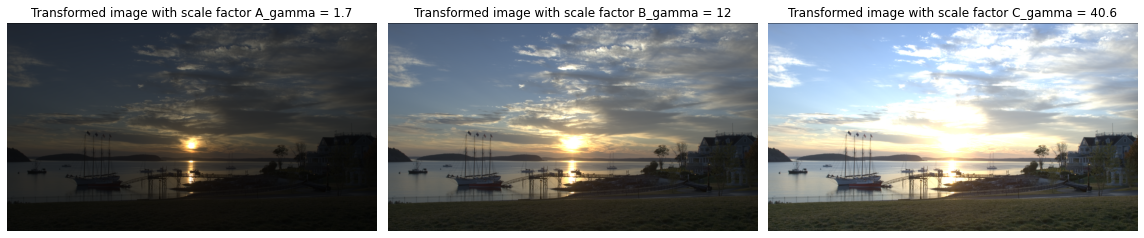

In [6]:
transformed_A = apply_transformation(sea,0, 1, A_gamma, 1/2.2)
transformed_B = apply_transformation(sea,0, 1, B_gamma, 1/2.2)
transformed_C = apply_transformation(sea,0, 1, C_gamma, 1/2.2)

fig, ax = plt.subplots(ncols=3, figsize=(16,8), dpi=72)
ax[0].imshow(transformed_A, vmin=0, vmax=1)
ax[0].set_title('Transformed image with scale factor A_gamma = '+ str(A_gamma))
ax[0].axis('off')

ax[1].imshow(transformed_B, vmin=0, vmax=1)
ax[1].set_title('Transformed image with scale factor B_gamma = '+ str(B_gamma))
ax[1].axis('off')

ax[2].imshow(transformed_C, vmin=0, vmax=1)
ax[2].set_title('Transformed image with scale factor C_gamma = '+ str(C_gamma))
ax[2].axis('off')

plt.tight_layout()
plt.show()

## b) 
## Influence of logarithmic transform
The formula for calculating the output image is given by:
$$
\ y = \frac{log_{10}(1+c*x)}{\log_{10}(1+c)}
$$
, where x is the input image and c is the coefficient to be adjusted.

In [7]:
def log_transform(input_image, c, gamma_coefficient):
    """
    The transformation that is being applied:
        output_image = log(1 + c*input_image)/log(1 + c)
        It is divided by log(1 + c) because this is the maximum value of intensity that the transformed image can take-
        the output image will be normalized
    Inputs:
        input image: input image in range [0,1]
        c: coefficient
    
    Output:
    output_image: calculated according to the above formula, takes values in range [0,1]
    """
    #A logarithmic scale is used to search for the parameter c to avoid sudden changes in intensity for small changes c
    input_log = np.log(1+(10**c)*input_image)/np.log(1+10**c)
    input_log_gamma = apply_gamma_correction(input_log, gamma_coefficient)
    return input_log_gamma
    #plt.figure(figsize=(32,20)); 
    #plt.imshow(input_log_gamma, vmin = 0, vmax = 1)
    
#interact(log_transform, input_image=fixed(sea), c=(0,5,0.1), gamma_coefficient = fixed(1/2.2))

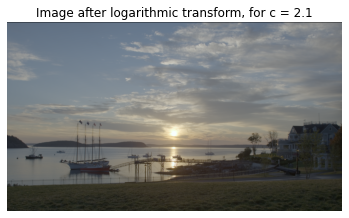

In [8]:
c = 2.1
sea_log = log_transform(sea, c, 1/2.2)

#Image plotting after logarithmic transformation
fig, ax = plt.subplots()
ax.set_title('Image after logarithmic transform, for c = ' + str(c))
plt.axis('off')
plt.imshow(sea_log, vmin = 0, vmax = 1)
plt.show()

As the parameter c increases, the image becomes brighter, and the lower-intensity pixels stretch to an ever-increasing range. For values of c about 2, the best contrast improvement was obtained. With further magnification, the pixels become too saturated, so the contrast worsens, the histogram of the image is grouped around higher values of the pixel intensity. The described effect can be seen in the figures below.

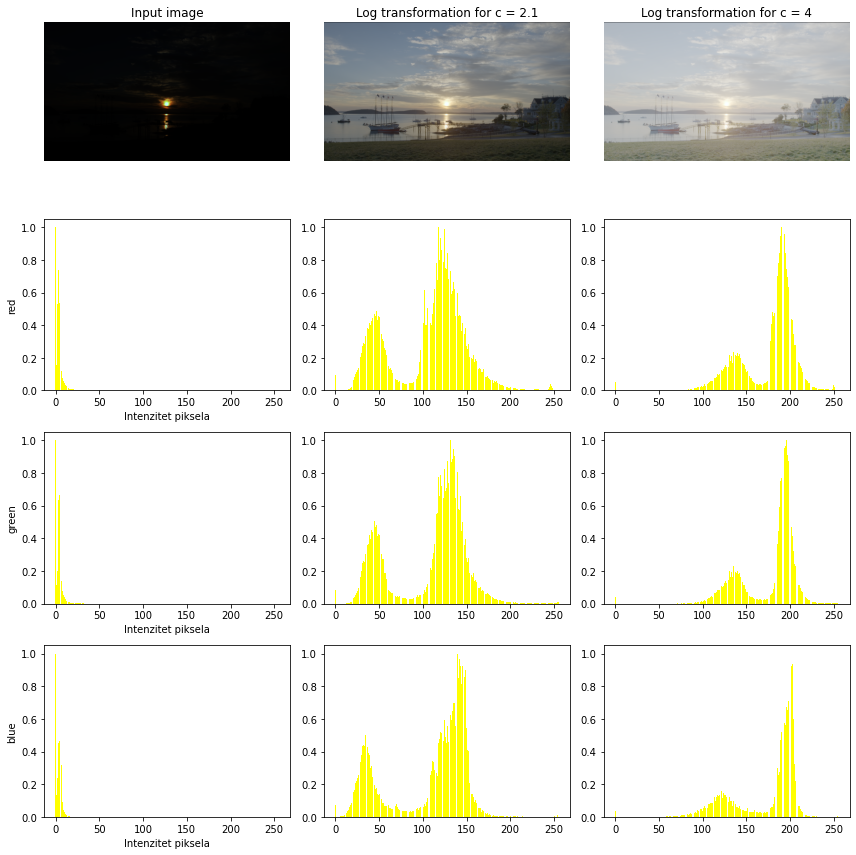

In [9]:
c_saturated = 4 
oplimal_contrast_image = log_transform(sea, 2.1, 1/2.2)
saturated_image = log_transform(sea, c_saturated, 1/2.2)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12,12))


# Drawing histograms of R, G, B components for the original image and those transformed by logarithmic transformation
for i, image in enumerate((img_as_ubyte(sea),img_as_ubyte(oplimal_contrast_image),img_as_ubyte(saturated_image))):
    for col, c_color in enumerate(('red','green','blue')):
        axes[0,i].imshow(image, cmap='jet', vmin=0, vmax=255); axes[0,i].set_axis_off()
        img_hist, bins = histogram(image[...,col], source_range='dtype')
        axes[col+1,i].bar(bins, img_hist/img_hist.max(), color='yellow')
        axes[col+1,0].set_ylabel(c_color)
        axes[col+1,0].set_xlabel('Intenzitet piksela')
        
axes[0,0].set_title('Input image')
axes[0,1].set_title('Log transformation for c = ' + str(c))
axes[0,2].set_title('Log transformation for c = ' + str(c_saturated))

plt.tight_layout()
plt.show()

## Influence of power transform

The formula for calculating the output image is given by:
$$
y = x^p\\
$$
, where x is the input image.

In [10]:
def power_transformation(input_image, power, gamma_coefficient):
    """
    Inputs:
        input_image: input image in range [0,1]
        power: power parameter
    
    Output:
    output_image: calculated according to the above formula, takes the valus in the range [0,1]
    """
    input_power = input_image**power
    output_image = apply_gamma_correction(input_power, gamma_coefficient)
    return output_image
    #plt.figure(figsize=(32,20)); 
    #plt.imshow(input_power_gamma, vmin = 0, vmax = 1)
    
#interact(power_transformation, input_image=fixed(sea), power=(0,2,0.1), gamma_coefficient = fixed(1/2.2))
    

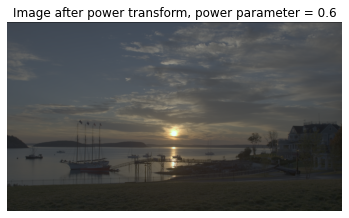

In [11]:
power = 0.6
sea_power = power_transformation(sea, power, 1/2.2)

#Image plotting after power transform
fig, ax = plt.subplots()
ax.set_title('Image after power transform, power parameter = ' + str(power))
plt.axis('off')
plt.imshow(sea_power, vmin = 0, vmax = 1)
plt.show()

As the exponent of the degree of transformation of the image increases, it becomes darker and the details are lost. The effect we would see on the histogram is that the pixel intensity values are grouped around lower values (inverse to logarithmic transformation) and the contrast is lost (this effect is also expressed for too small degree values).

# c)
## Mapping that I would suggest

The goal is to convey the atmosphere of the sunrise, so the emphasis is on it, and the environment (house) should be in the shade, but still visible. A rescaling transformation was applied, which gives a larger range to the lighter pixels, and then a gamma correction, which additionally brightens the pixels (because it is actually a logarithmic transform).

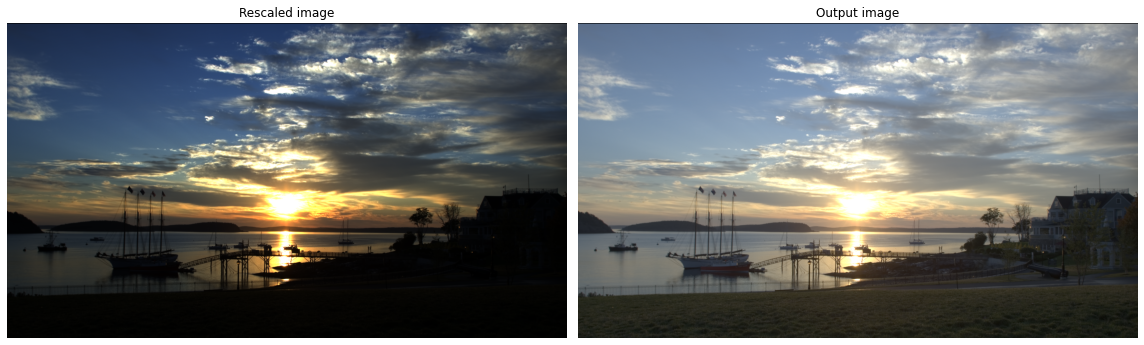

In [12]:
high_in = np.percentile(sea.flatten(),98) 
sea_rescaled = rescale_intensity(sea, in_range=(0, high_in), out_range=(0,1))

output_image = apply_gamma_correction(sea_rescaled, 1/2.2)

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(sea_rescaled, vmin = 0, vmax = 1)
ax[0].set_title('Rescaled image')
ax[0].axis('off')

ax[1].imshow(output_image, vmin = 0, vmax = 1)
ax[1].set_title('Output image')
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Task 2

## Marilyn Monroe

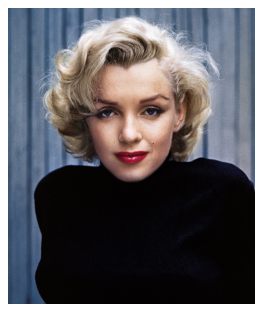

In [4]:
marilyn = imageio.imread('images/marilyn.jpg')

fig, axes = plt.subplots(ncols=1, figsize=(8,4), dpi=80)
axes.imshow(marilyn, vmin=0, vmax=255)
axes.axis('off')
plt.tight_layout()
plt.show()

### task - selective decolorization
Selective decolorization means that a color image is converted to a gray image except
certain parts that need to remain in color. It is not allowed to physically set coordinates
masks, but the selection should be done solely on the basis of the color of the area.

**Solution**: Since only red color needs to be kept, better seperability in color space can be achieved when original image is represented in *Lab* color space. **(1)** Red mask selects red pixels of lips by tresholding channels. Since perfect selection isn't possible there is some impusle noise in the mask that can be attenuated using madian fiter. Mask is applied on the image to be decolorized. Treshold selection causes eroded edges, so gaussian filter is applied to smooth them out.

**(1)** *L* value indicates lightness, and *a* and *b* are chromaticity coordinates. On the color space diagram, *L* is represented on a vertical axis with values from 0 (black) to 100 (white). The *a* value indicates red-green component of a color. The yellow and blue components are represented on the *b* axis. At the center of the plane is neutral or achromatic. 
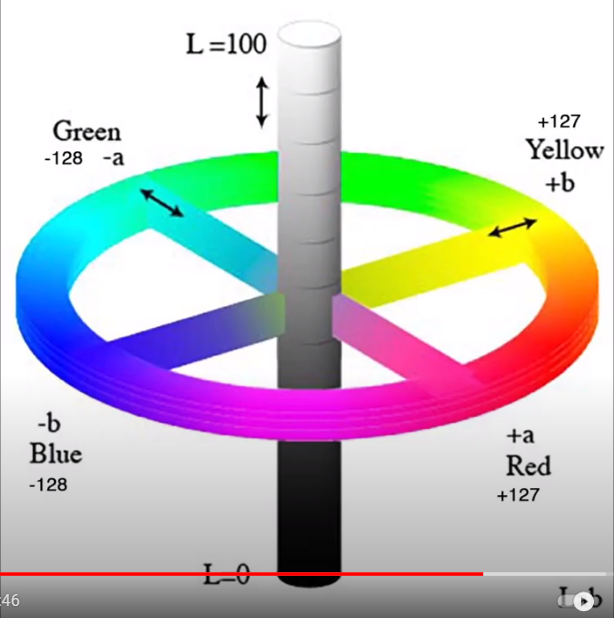

In [1]:
def selective_decolorisation_lips(input_image):
    """
    Input: input_Image: RGB input image in range [0,255]
          
    Output: image with colorized lips only
    """
    M,N,C = np.shape(input_image)

    # Initialization of the output image
    output_image = np.zeros((M,N,C))
    
    input_image_lab = rgb2lab(input_image)
    # Grayscale image is kept - L channel 
    output_image[:,:,0] = input_image_lab[:,:,0]
    
    # Boolean mask for red color that selects lips
    red_treshold = 25 #selects red pixel of interest - intensities of image that are greater than red_treshold are
    #kept in the mask for red color
    red_mask = input_image_lab[:,:,1] > red_treshold
    
    # red_mask keeps some pixels that do not belong to lips and misses some pixels that belong to lips - they represent
    # impusle noise, that can be attenuated with median filter
    median_filter = np.ones(shape=(21,21))
    red_mask_filtered = median(red_mask, median_filter)

    # red_mask selects pixels of input_image to be kept for the output image
    output_image[red_mask_filtered,1] = input_image_lab[red_mask_filtered,1]
    output_image[red_mask_filtered,2] = input_image_lab[red_mask_filtered,2]
     
    # Treshold selection causes eroded edges, so gaussian filter is applied to smooth them out
    output_image[:,:,1] = gaussian(output_image[:,:,1], sigma=6)
    output_image[:,:,2] = gaussian(output_image[:,:,2], sigma=6) 
    
    output_image_rgb = lab2rgb(output_image)
    #print(np.min(output_image_rgb))
    #print(np.max(output_image_rgb))
    
    # Displaying intermediate and final results
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(20,22))
    axes[0,0].imshow(input_image, vmin = 0, vmax = 255, cmap = 'jet'); 
    axes[0,0].set_title('Input image');axes[0,0].axis('off');
    
    axes[0,1].imshow(np.uint8(red_mask), vmin=0, vmax=1, cmap = 'gray');
    axes[0,1].set_title('Treshold red mask');axes[0,1].axis('off');
    
    axes[1,0].imshow(np.uint8(red_mask_filtered), vmin=0, vmax=1, cmap = 'gray');
    axes[1,0].set_title('Treshold red mask filtered with median filter');axes[1,0].axis('off');
    
    axes[1,1].imshow(output_image_rgb, vmin=0, vmax=1, cmap = 'jet');
    axes[1,1].set_title('Selectively decolorized image');axes[1,1].axis('off');
    
    plt.tight_layout()
    plt.show()
    
    return output_image_rgb
    

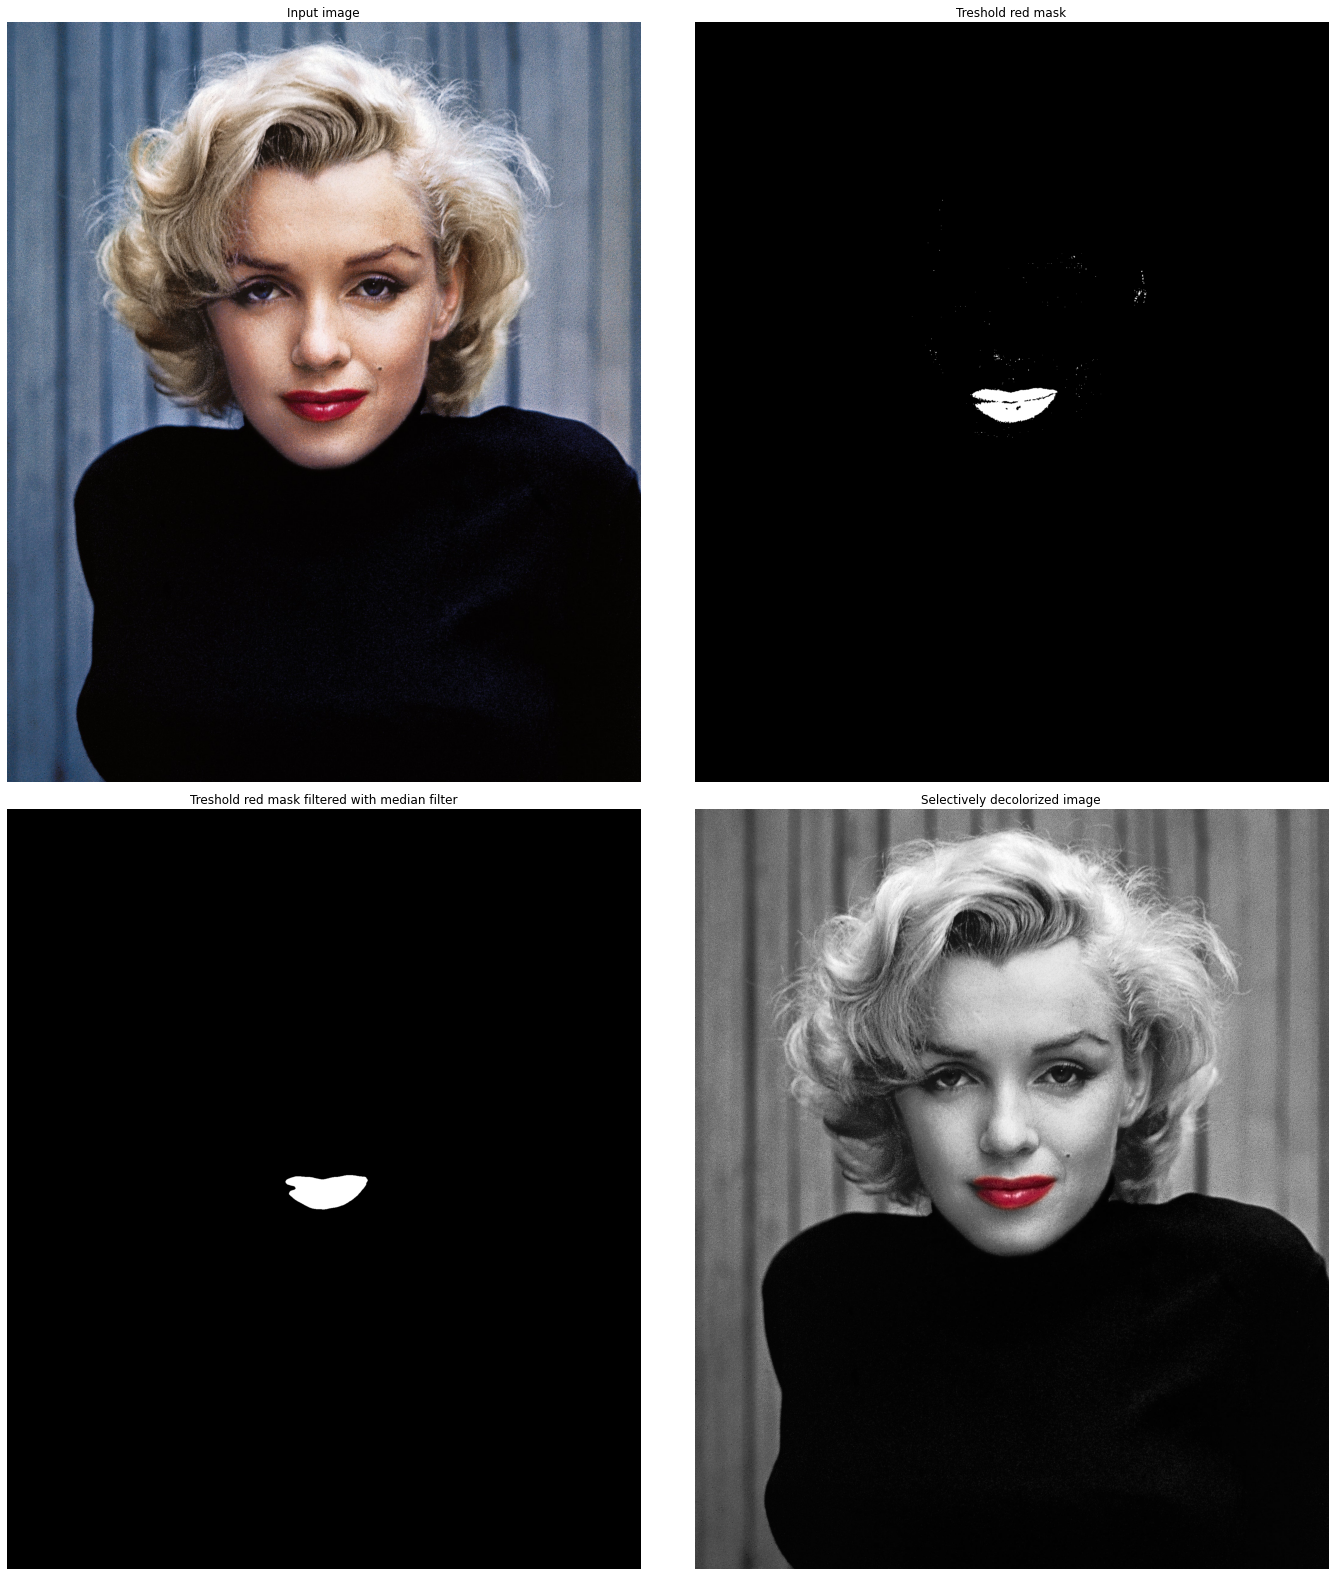

In [5]:
marilyn_decolorized = selective_decolorisation_lips(marilyn)

## Yellow umbrella

Same approach is applied to this problem, except yellow mask is obtained by tresholding *b* channel of the original image represented in *Lab* color space. Sizes of madian and gaussian filters are adapted as well.

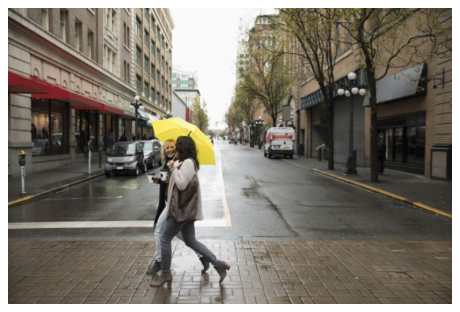

In [76]:
# Image to be decolorized
input_image = imageio.imread('images/street.jpg')

fig, axes = plt.subplots(ncols=1, figsize=(8,4), dpi=80)
axes.imshow(input_image, vmin=0, vmax=255)
axes.axis('off')
plt.tight_layout()
plt.show()

In [126]:
def selective_decolorisation_umbrella(input_image):
    """
    Input: input_Image: RGB input image in range [0,255]
          
    Output: image with colorized lips only
    """
    M,N,C = np.shape(input_image)

    # Initialization of the output image
    output_image = np.zeros((M,N,C))
    
    input_image_lab = rgb2lab(input_image)
    # Grayscale image is kept - L channel 
    output_image[:,:,0] = input_image_lab[:,:,0]
    
    # Boolean mask for yellow color that selects umbrella
    yellow_treshold = 43 #selects yellow pixel of interest - intensities of image that are greater than yellow_treshold 
    # are kept in the mask for yellow color
    yellow_mask = input_image_lab[:,:,2] > yellow_treshold
 
    # yellow_mask keeps some pixels that do not belong to umprella and misses some pixels that belong to lips - they represent
    # impusle noise, that can be attenuated with median filter
    median_filter = np.ones(shape=(7,7))
    yellow_mask_filtered = median(yellow_mask, median_filter)
    
    # red_mask selects pixels of input_image to be kept for the output image
    output_image[yellow_mask_filtered,1] = input_image_lab[yellow_mask_filtered,1]
    output_image[yellow_mask_filtered,2] = input_image_lab[yellow_mask_filtered,2]
     
    # Treshold selection causes eroded edges, so gaussian filter is applied to smooth them out
    output_image[:,:,1] = gaussian(output_image[:,:,1], sigma=3)
    output_image[:,:,2] = gaussian(output_image[:,:,2], sigma=3) 
    
    output_image_rgb = lab2rgb(output_image)
    #print(np.min(output_image_rgb))
    #print(np.max(output_image_rgb))
    
    # Displaying intermediate and final results
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(22,15))
    axes[0,0].imshow(input_image, vmin = 0, vmax = 255, cmap = 'jet'); 
    axes[0,0].set_title('Input image');axes[0,0].axis('off');
    
    axes[0,1].imshow(np.uint8(yellow_mask), vmin=0, vmax=1, cmap = 'gray');
    axes[0,1].set_title('Treshold yellow mask');axes[0,1].axis('off');
    
    axes[1,0].imshow(np.uint8(yellow_mask_filtered), vmin=0, vmax=1, cmap = 'gray');
    axes[1,0].set_title('Treshold yellow mask filtered with median filter');axes[1,0].axis('off');
    
    axes[1,1].imshow(output_image_rgb, vmin=0, vmax=1, cmap = 'jet');
    axes[1,1].set_title('Selectively decolorized image');axes[1,1].axis('off');
    
    plt.tight_layout()
    plt.show()
    
    return output_image_rgb
    

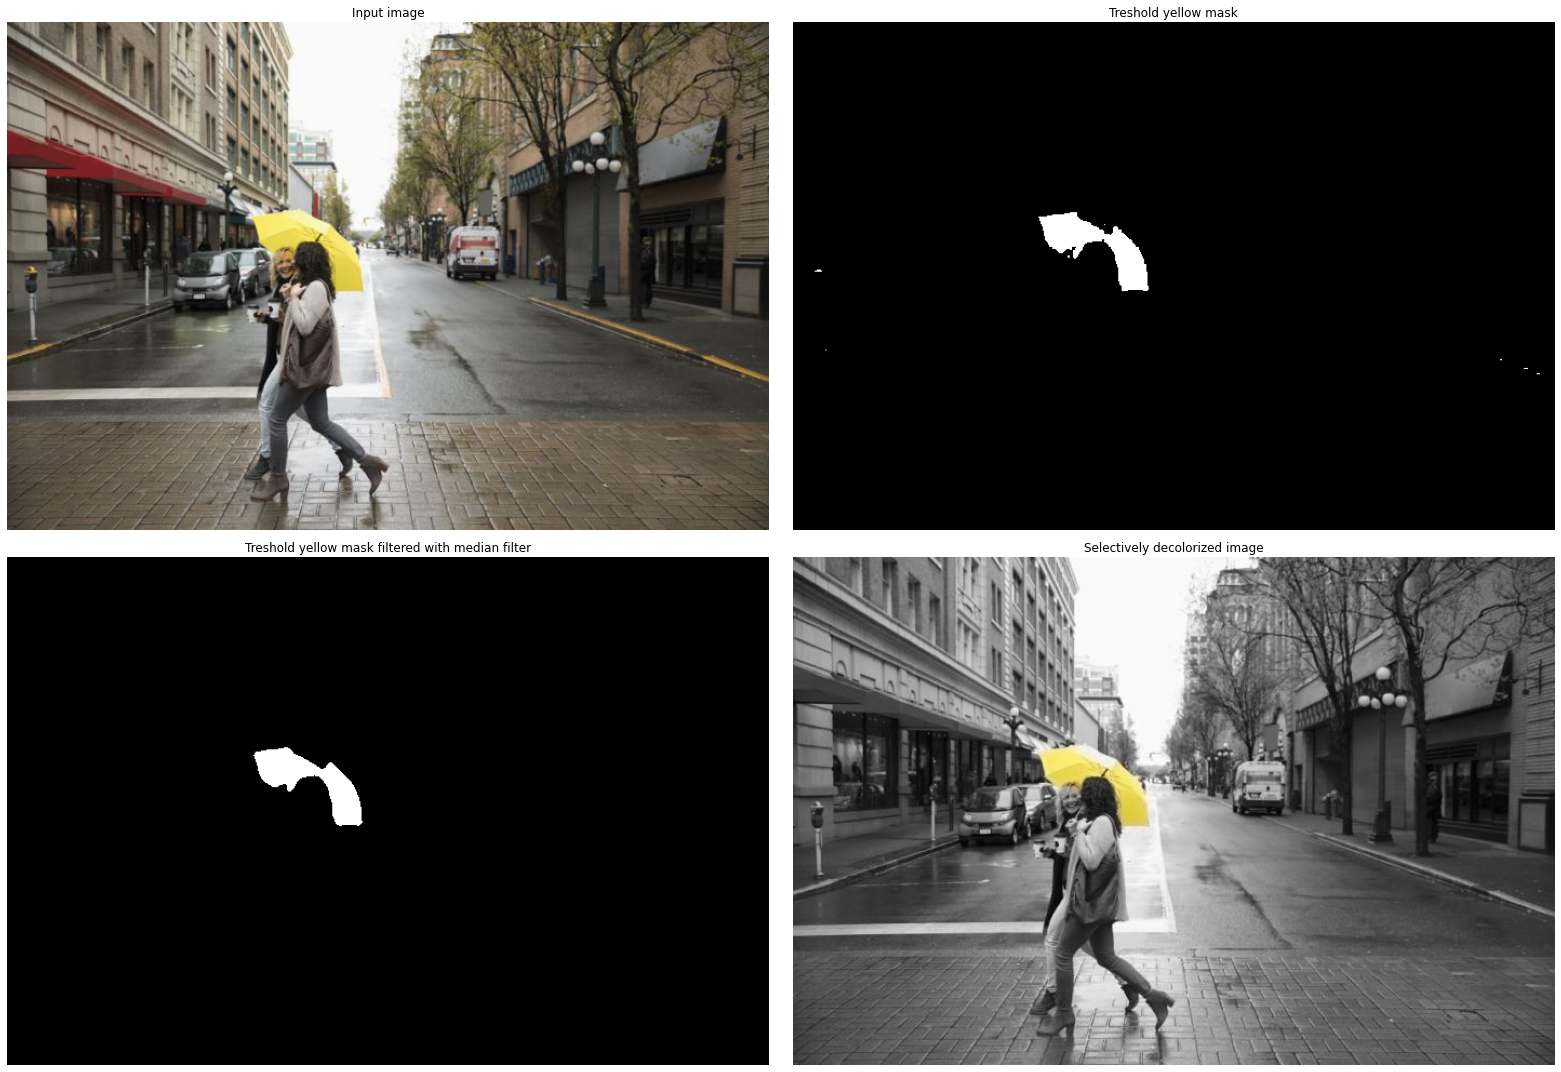

In [127]:
decolorized_image = selective_decolorisation_umbrella(input_image)

# Task 3
## My implementation of bilateral filter

During the implementation, I tried to make the algorithm as efficient as possible, and it was implemented using a window that selects the appropriate part of the padded image for the local neighborhood and matrix multiplication. It is made for black and white images.
At the beginning, validations of the passed parameters and data types were performed. In case of any of the errors, the function returns the original image and prints an error message.

In [130]:
def gaussian(x_square, sigma):
    """
    An auxiliary function that returns a matrix of Gaussian distributed numbers.
    
    Inputs:
        - x_square: the square of the distance between two points in a plane
        - sigma: standard deviation
    """
    return np.exp(-0.5*x_square/sigma**2)

def bilateral_filter(x, radius, sigma_s, sigma_r):
    """
    Inputs:
        - x: input 2D image, one of the layers of the black and white image should be passed
              For a color image, call the function over each layer individually
        - radius: the half-height of a square-shaped window, which indicates the local neighborhood of a particular
                  pixel
        - sigma_s: standard deviation for the spatial component of the filter
        - sigma_r: standard deviation for the intensity component
    
    Output:
        - transfromed image
        
    """
    window_dimension = 2*radius+1
    if((2*radius+1) <= 0):
        print('Window size is not a positive number. Adjust the radius so that 2 * radius + 1 is a positive number. \
        The input image is returned')
        return x
    if(not(isinstance(window_dimension, int))):
        print('Window size is not an integer. Adjust the radius so that 2 * radius + 1 is an integer. \
        The input image is returned')
        return x
    if(sigma_s < 0):
        print('The standard deviation for the spatial mask must not be negative! The input image is returned')
        return x
    if((sigma_r < 0) | (sigma_r > 1)):
        print('The standard deviation for intensities must not be outside the range [0,1]!The input image is returned')
        return x
    
    if(x.dtype == np.uint8):
        x = img_as_float(x)
    elif(not(x.dtype == np.double)):
        raise TypeError('The image must be of type numpy.uint8 or numpy.double! \
        Passed image is of type ' + str(img.dtype))

       
    out = np.zeros((x.shape[0], x.shape[1])) # Izlazna slika
    # Pad the image by repeating the edge pixels
    img_paded = np.pad(x, ((radius, radius), (radius, radius)), 'edge') 
    
    # Defining the local neighborhood of the current pixel
    s = range(-radius,radius+1)
    t = range(-radius,radius+1)
    # Coordinates of all pixels within the local neighborhood of the pixel that is currently being processed
    S, T = np.meshgrid(s,t) 
    
    # Creating weights that depend on the distance from the pixel currently being processed
    gauss_mask = gaussian(S**2 + T**2, sigma_s)
 
    # Creating weight coefficients that depend on the intensity of the local neighborhood pixel and the pixel 
    # that is currently being processed
    for x_index in range(radius, img_paded.shape[0]-radius):
        for y_index in range(radius, img_paded.shape[1]-radius):
            mask_intensity = img_paded[(x_index-radius):(x_index-radius+2*radius+1),\
                                       (y_index-radius):(y_index-radius+2*radius+1)]-img_paded[x_index,y_index]
            weigts_intensity = gaussian(mask_intensity**2, sigma_r)
            # By multiplying the corresponding weights, we obtain a final matrix of weights
            weights = gauss_mask*weigts_intensity
            # Normalization to preserve the DC component of the image
            weights_sum = np.sum(weights.flatten())
            # Apply the transformation to each pixel of the input image
            out[x_index-radius,y_index-radius] =np.sum((weights*img_paded[(x_index-radius):(x_index-radius+2*radius+1)\
                                                ,(y_index-radius):(y_index-radius+2*radius+1)]).flatten())/weights_sum
    return out

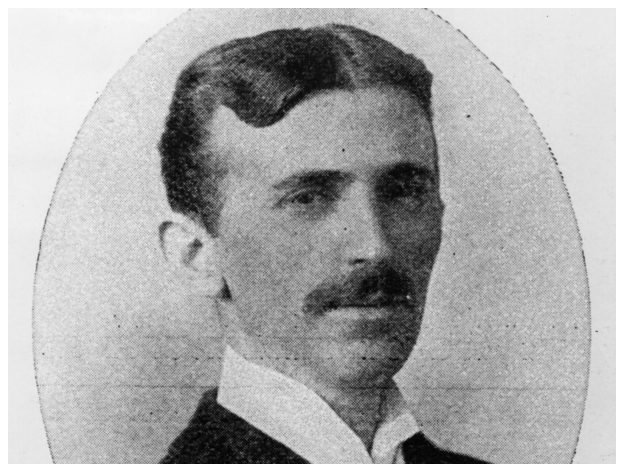

In [131]:
# Import and display test image
input_image = imageio.imread('images/tesla.jpg')

fig, axes = plt.subplots(ncols=1, figsize=(10,6), dpi=80)
axes.imshow(input_image, vmin=0, vmax=255, cmap = 'gray')
axes.axis('off')
plt.tight_layout()
plt.show()

The image is quite noisy, so we expect the bilateral filter to suppress the noise to some extent, while preserving the edges.

### Comparisonof  my filter realization and *skimage.restoration.denoise_bilateral*, while changing the radius:

In [132]:
# Filter testing

r = [2, 4, 20, 40]
sigma_s = 5
sigma_r = 0.3

custom_filtered_image = [] # a list for storing output images using my algorithm
builtin_filtered_img = [] # a list for storing output images using the built-in function
t_norm_custom = [] # a list for storing execution time using my algorithm
t_norm_builtin = []# a list for storing execution time using built-in function

for i in range(len(r)):
    # Applying my algorithm
    start = time.time() 
    custom_filtered_image.append(bilateral_filter(input_image, r[i], sigma_s, sigma_r))
    end = time.time()
    execution_time = (end - start)
    t_norm_custom.append(round(execution_time*1e6,3)/np.size(input_image))

    # The application of the built-in function, image must be in the range [0,1]
    input_image_double = img_as_float(input_image)
    start = time.time()
    builtin_filtered_img.append(denoise_bilateral(input_image_double, win_size=2*r[i]+1, sigma_color=sigma_r, \
                                                  sigma_spatial=sigma_s))
    end = time.time()
    execution_time = (end - start)
    t_norm_builtin.append(round(execution_time*1e6,3)/np.size(input_image))

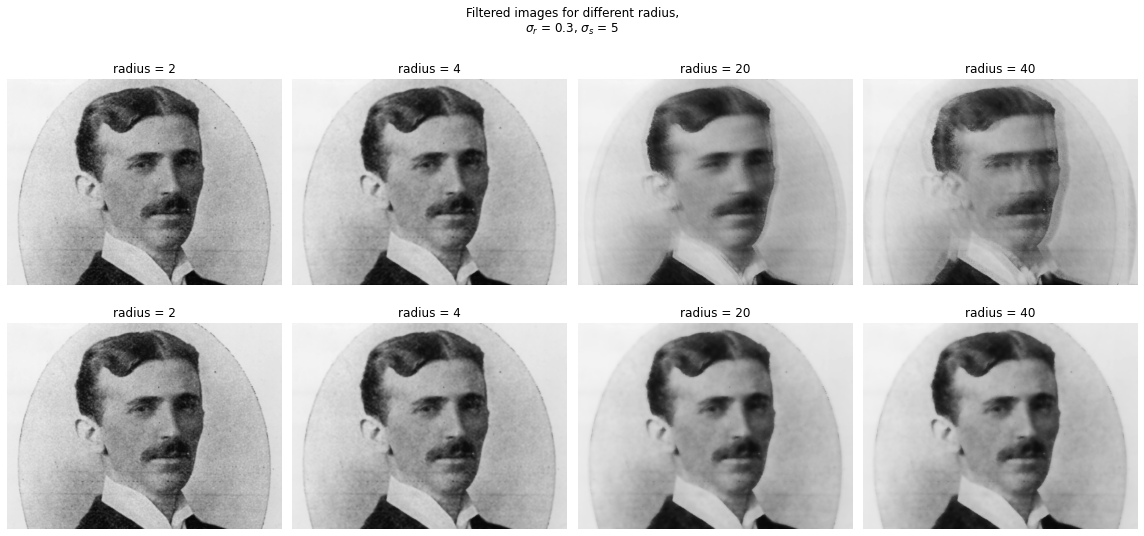

In [133]:
# Display the results of both filters, in the first row is the result of the built-in filter, and in the second mine
fig, axes = plt.subplots(2, 4, figsize=(16,8));
for fcn, fcn_name in enumerate(('scikit image', 'custom' )):
    for i in range(len(r)):
        if(fcn):
            axes[fcn,i].imshow(custom_filtered_image[i], vmin = 0, vmax = 1, cmap = 'gray')
        else:
            axes[fcn,i].imshow(builtin_filtered_img[i], vmin = 0, vmax = 1, cmap = 'gray')
        axes[fcn,i].set_title('radius = ' + str(r[i]) )
        axes[fcn,i].axis('off')
        axes[fcn,0].set_ylabel(fcn_name)
fig.suptitle('Filtered images for different radius,\n$\sigma_r$ = ' + str(sigma_r)+ ', $\sigma_s$ = ' + str(sigma_s))             
plt.tight_layout()
plt.show()


Graphical display of execution speed comparison:

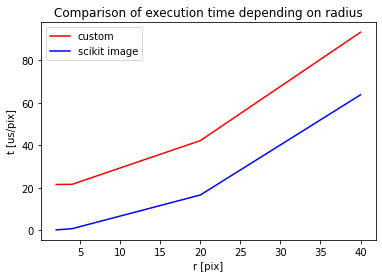

In [134]:
plt.plot(r, t_norm_custom, color = 'r', label = 'custom')
plt.plot(r, t_norm_builtin, color = 'b', label = 'scikit image')
plt.ylabel('t [us/pix]')
plt.xlabel('r [pix]')
plt.title('Comparison of execution time depending on radius')
plt.legend()
plt.show()

**Conclusion:** Execution time is slightly longer (about 20 milliseconds) when executing the function that I have implemented, however the resulting image is much better. For a radius> = 20 the built-in function returns an image where almost all details are lost, and is unusable. Increasing the radius takes into account the growing neighborhood of the pixels, resulting in a more uniform pixel intensity. This suppresses noise, which can be seen in the second row of displayed images.

### Variation of the standard deviation of intensity of bilateral filer:
Execution time comparison is irrelevant, because changing this parameter does not affect the execution time, but only the quality.

In [135]:
r = 10
sigma_s = 5
sigma_r = [0.1, 0.5, 1]

custom_filtered_image.clear() # a list for storing output images using my algorithm
builtin_filtered_img.clear() 
t_norm_custom.clear() # a list for storing execution time using my algorithm
t_norm_builtin.clear()

for i in range(len(sigma_r)):
    # Primena mog algoritma
    custom_filtered_image.append(bilateral_filter(input_image, r, sigma_s, sigma_r[i]))
    

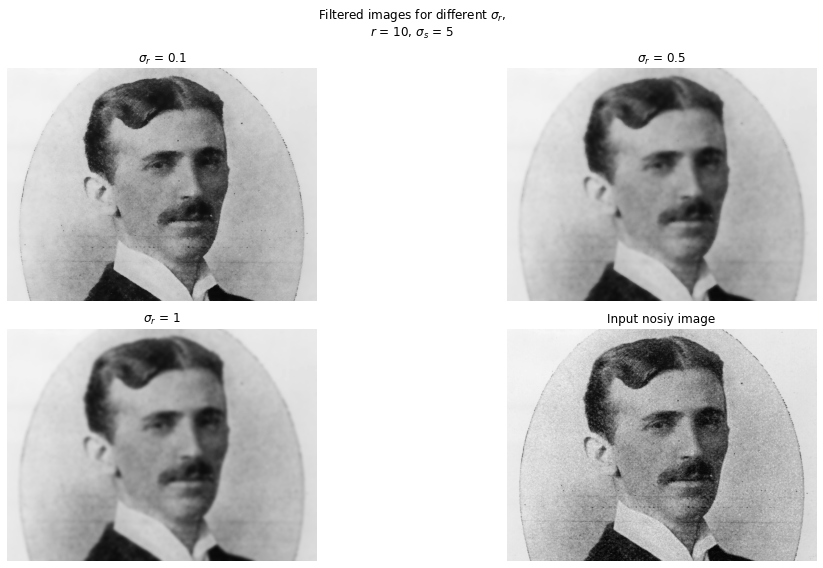

In [136]:
fig, axes = plt.subplots(2,2, figsize=(16,8));

axes[0, 0].imshow(custom_filtered_image[0], cmap = 'gray', vmin = 0, vmax = 1)
axes[0, 0].set_title('$\sigma_r$ = ' + str(sigma_r[0]))
axes[0, 0].axis('off')

axes[0, 1].imshow(custom_filtered_image[1], cmap = 'gray', vmin = 0, vmax = 1)
axes[0, 1].set_title('$\sigma_r$ = ' + str(sigma_r[1]))
axes[0, 1].axis('off')

axes[1, 0].imshow(custom_filtered_image[2], cmap = 'gray', vmin = 0, vmax = 1)
axes[1, 0].set_title('$\sigma_r$ = ' + str(sigma_r[2]))
axes[1, 0].axis('off')

axes[1, 1].imshow(input_image, cmap = 'gray', vmin = 0, vmax = 255)
axes[1, 1].set_title('Input nosiy image')
axes[1, 1].axis('off')

fig.suptitle('Filtered images for different $\sigma_r$,\n$r$ = ' + str(r)+ ', $\sigma_s$ = ' + str(sigma_s))        
plt.tight_layout()
plt.show()


**Conclusion**: Changing the standard deviation of intensity does not degrade the image as when the radius was being changed, which was expected. For small values of the standard deviation of intensity (which tend to zero) we get the effect of averaging the pixel with itself, and the output for $\sigma_r = 0.1$ is very similar to the input image. For the maximum allowed $\sigma_r = 1$, the effect of only spatial averaging remains, ie only the part of the transformation that refers to the Gaussian filter, and the sharpness of the edge is not the best preserved.

### Variation of the standard deviation of the spatial component of bilateral filer:
Here,execution time comparison is irrelevant as well, because changing this parameter does not affect the execution time, but only the quality.

In [137]:
r = 10
sigma_s = [1, 15, 30]
sigma_r = 0.2

custom_filtered_image.clear() # a list for storing output images using my algorithm
t_norm_custom.clear() # a list for storing execution time using my algorithm

for i in range(len(sigma_s)):
    # Primena mog algoritma
    custom_filtered_image.append(bilateral_filter(input_image, r, sigma_s[i], sigma_r))
    

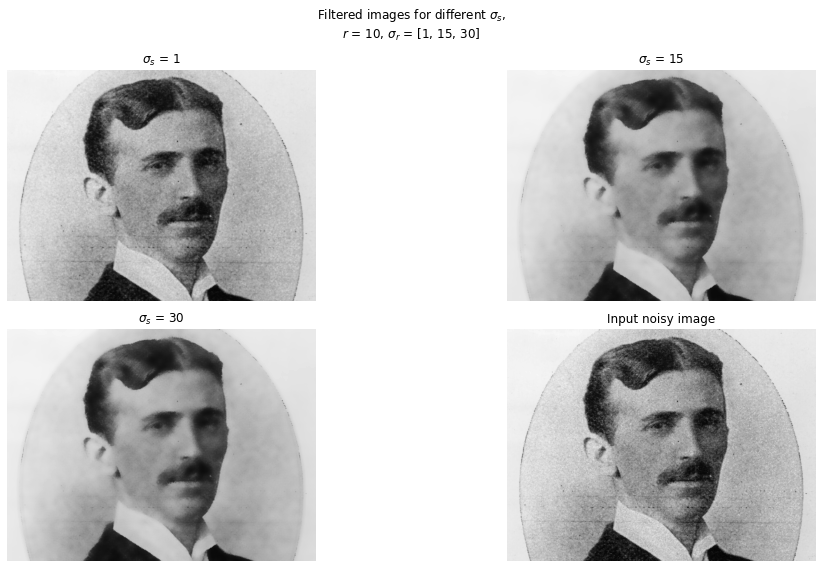

In [138]:
fig, axes = plt.subplots(2,2, figsize=(16,8));

axes[0, 0].imshow(custom_filtered_image[0], cmap = 'gray', vmin = 0, vmax = 1)
axes[0, 0].set_title('$\sigma_s$ = ' + str(sigma_s[0]))
axes[0, 0].axis('off')

axes[0, 1].imshow(custom_filtered_image[1], cmap = 'gray', vmin = 0, vmax = 1)
axes[0, 1].set_title('$\sigma_s$ = ' + str(sigma_s[1]))
axes[0, 1].axis('off')

axes[1, 0].imshow(custom_filtered_image[2], cmap = 'gray', vmin = 0, vmax = 1)
axes[1, 0].set_title('$\sigma_s$ = ' + str(sigma_s[2]))
axes[1, 0].axis('off')

axes[1, 1].imshow(input_image, cmap = 'gray', vmin = 0, vmax = 255)
axes[1, 1].set_title('Input noisy image')
axes[1, 1].axis('off')

fig.suptitle('Filtered images for different $\sigma_s$,\n$r$ = ' + str(r)+ ', $\sigma_r$ = ' + str(sigma_r))        
plt.tight_layout()
plt.show()

**Consclusion**: By increasing the standard deviation of the Gaussian component of the filter, we effectively expand and decrease the peak of the Gaussian probability density function, and the consequence is that we give higher weights to pixels that are further away in the local neighborhood of the pixels we are currently observing. The effect of this is that we get more and more uniform lighting, small details are lost. What is desirable is that the noise is increasingly suppressed. The edges are preserved because there is also the influence of the filter component, which also takes into account the pixel intensities. When $\sigma_s = 1$ the noise is not suppressed because the pixels in the local neighborhood have very little effect, and the averaging of the pixels is practically done by itself when $\sigma_s$ weighs zero.

## NOTE:
Increasing one of three parameres, while other are kept constant can sigificantly change the shape of the bilateral filter, so we end up with the 'suboptimal' filter. Better and more meaningful approach is to make connection between the values of two standard deviations, so that they change with the respect to one another.

In [146]:
r = [2, 4, 20, 40]
sigma_s = [5, 10, 15, 20]
sigma_r = [x / 20 for x in sigma_s]

In [147]:
custom_filtered_image.clear()# a list for storing output images using my algorithm
builtin_filtered_img.clear() # a list for storing output images using the built-in function
t_norm_custom .clear() # a list for storing execution time using my algorithm
t_norm_builtin.clear()# a list for storing execution time using built-in function

for i in range(len(r)):
    # Applying my algorithm
    start = time.time() 
    custom_filtered_image.append(bilateral_filter(input_image, r[i], sigma_s[i], sigma_r[i]))
    end = time.time()
    execution_time = (end - start)
    t_norm_custom.append(round(execution_time*1e6,3)/np.size(input_image))

    # The application of the built-in function, image must be in the range [0,1]
    input_image_double = img_as_float(input_image)
    start = time.time()
    builtin_filtered_img.append(denoise_bilateral(input_image_double, win_size=2*r[i]+1, sigma_color=sigma_r[i], \
                                                  sigma_spatial=sigma_s[i]))
    end = time.time()
    execution_time = (end - start)
    t_norm_builtin.append(round(execution_time*1e6,3)/np.size(input_image))

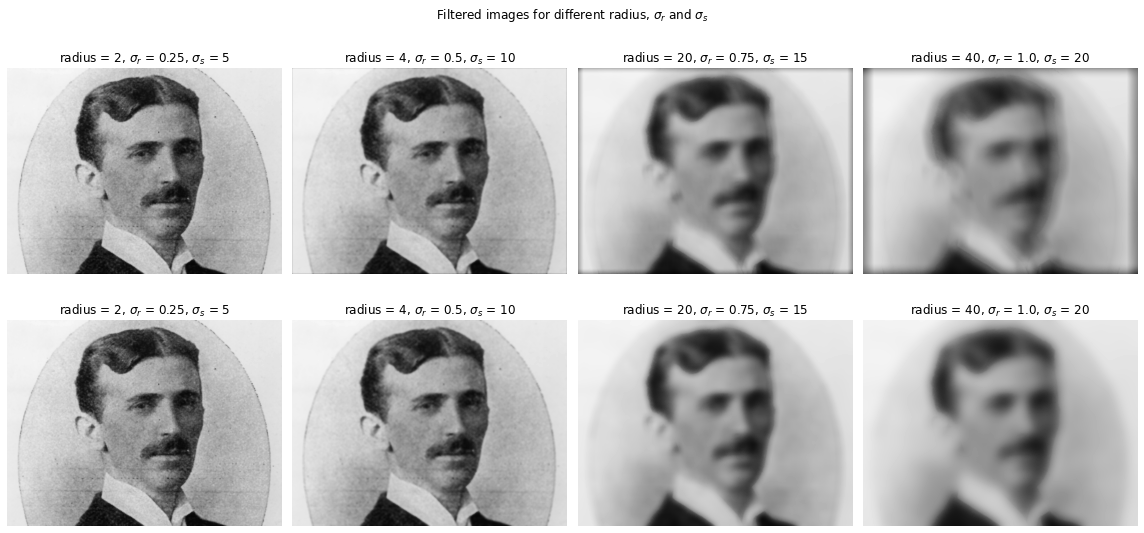

In [149]:
# Display the results of both filters, in the first row is the result of the built-in filter, and in the second mine
fig, axes = plt.subplots(2, 4, figsize=(16,8));
for fcn, fcn_name in enumerate(('scikit image', 'custom' )):
    for i in range(len(r)):
        if(fcn):
            axes[fcn,i].imshow(custom_filtered_image[i], vmin = 0, vmax = 1, cmap = 'gray')
        else:
            axes[fcn,i].imshow(builtin_filtered_img[i], vmin = 0, vmax = 1, cmap = 'gray')
        axes[fcn,i].set_title('radius = ' + str(r[i]) + ', $\sigma_r$ = ' + str(sigma_r[i]) + ', $\sigma_s$ = ' + str(sigma_s[i]) )
        axes[fcn,i].axis('off')
        axes[fcn,0].set_ylabel(fcn_name)
fig.suptitle('Filtered images for different radius, $\sigma_r$ and $\sigma_s$')             
plt.tight_layout()
plt.show()


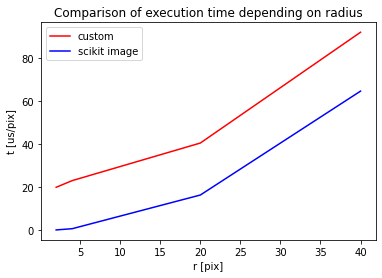

In [150]:
plt.plot(r, t_norm_custom, color = 'r', label = 'custom')
plt.plot(r, t_norm_builtin, color = 'b', label = 'scikit image')
plt.ylabel('t [us/pix]')
plt.xlabel('r [pix]')
plt.title('Comparison of execution time depending on radius')
plt.legend()
plt.show()